[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/12_monsters_and_mixtures.ipynb)

# Chapter 12 - Monsters and Mixtures


## Imports and utility functions


In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.X
    
    !pip install watermark
    !pip install arviz
    !pip install tensorflow_probability==0.9.0

In [2]:
%load_ext watermark

In [3]:
from functools import partial

# Core
import numpy as np
import arviz as az
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats as stats
from scipy.interpolate import griddata
from scipy.interpolate import BSpline

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy 1.18.1
tensorflow 2.1.0
tensorflow_probability 0.9.0
arviz 0.6.1
scipy 1.4.1
pandas 0.25.3


In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [6]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  USE_XLA = False
else:
  USE_XLA = True

### Tensorflow MCMC sampling helpers

In [7]:
NUMBER_OF_CHAINS  = 2
NUMBER_OF_SAMPLES = 1000
NUMBER_OF_BURNIN  = 1000

def _tile_init(init, num_repeats):
    # num_repeats is equivalent to the number of the chains
    # we want to use
    return [tf.tile(tf.expand_dims(tens, 0), [num_repeats] + [1] * tens.ndim) for tens in init]

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: np.swapaxes(v.numpy(), 1, 0)
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )

# experimental_compile with True is not working
# and given an error that DT_STRING is not supported by XLA
@tf.function(autograph=False, experimental_compile=USE_XLA)
def run_chain(init_state, step_size, target_log_prob_fn, num_chains=NUMBER_OF_CHAINS,
              num_samples=NUMBER_OF_SAMPLES, burnin=NUMBER_OF_BURNIN):    

    def _trace_fn(_, pkr):
        return (
            pkr.inner_results.target_log_prob,
            pkr.inner_results.leapfrogs_taken,
            pkr.inner_results.has_divergence,
            pkr.inner_results.energy,
            pkr.inner_results.log_accept_ratio
        )

    nuts_kernel = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn,
        step_size=step_size)    
    
    kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=nuts_kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*burnin),
        step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(step_size=new_step_size),
        step_size_getter_fn=lambda pkr: pkr.step_size,
        log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio
    )    
    
    results, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=kernel,
        trace_fn=_trace_fn)
    return results, sampler_stat

def sample_from_posterior(jdc, observed_data, params, 
                          num_chains=NUMBER_OF_CHAINS,
                          num_samples=NUMBER_OF_SAMPLES, 
                          burnin=NUMBER_OF_BURNIN):
    # we get the sample from our model definition
    # that will act as the init state for the chain
    samples = jdc.sample()
    samples_without_outcome = samples[:-1]

    # need to convert it (tuple) to list else facing issues
    init_state = [o for o in samples_without_outcome]
    
    tiled_init_state = _tile_init(init_state, NUMBER_OF_CHAINS)

    target_log_prob_fn = lambda *x: jdc.log_prob(x + (observed_data,))    

    step_size = 0.1

    results, sample_stats = run_chain(tiled_init_state, 
                                      step_size=step_size,
                                      target_log_prob_fn=target_log_prob_fn,
                                      num_chains=num_chains,
                                      num_samples=num_samples, 
                                      burnin=burnin)

    stat_names = ['lp', 'tree_size',
                  'diverging', 'energy', 'mean_tree_accept']
    sampler_stats = dict(zip(stat_names, sample_stats))
    posterior = dict(zip(params, results))

    return _trace_to_arviz(trace=posterior, sample_stats=sampler_stats)

### Dataset URLs


In [8]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"

UCBADMIT_DATASET_PATH = f"{_BASE_URL}/UCBadmit.csv"
KLINE_DATASET_PATH = f"{_BASE_URL}/Kline.csv"

## Code 12.1


A beta distribution is a probability distribution for probabilities !

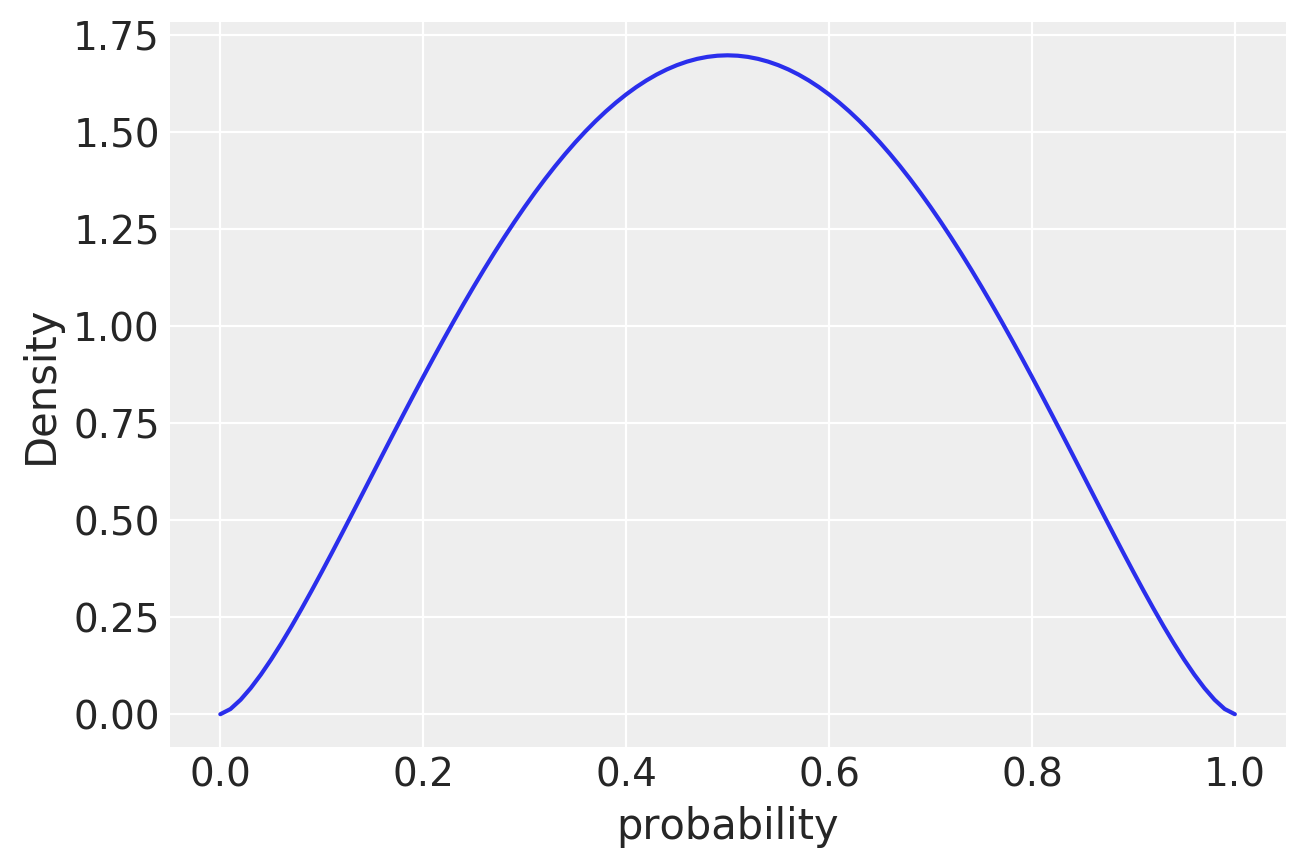

In [9]:
pbar = 0.5   # mean
theta = 5    # total concentration

alpha = pbar * theta
beta = (1 - pbar) * theta

x = np.linspace(0, 1, 101)

plt.plot(x, tf.exp(tfd.Beta(alpha, beta).log_prob(x)))
plt.gca().set(xlabel="probability", ylabel="Density");

## Code 12.2

In [10]:
d = pd.read_csv(UCBADMIT_DATASET_PATH, sep=";")
d["gid"] = (d["applicant.gender"] != "male").astype(int)

In [11]:
def model_12_1(gid, N):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=2))
      phi = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      theta = phi + 2
      pbar = tf.sigmoid(tf.squeeze(tf.gather(alpha, gid, axis=-1)))        
        
      # prepare the concentration vector
      concentration1 = pbar * theta
      concentration0 = (1 - pbar) * theta    
    
      concentration = tf.stack([concentration1, concentration0], axis=-1)
        
      # outcome A i.e. admit  
      # since it is a multinomial we will have K = 2
      # note -  this does not really behave like Binomial in terms of the sample shape
      A = yield tfd.Independent(tfd.DirichletMultinomial(total_count=N, concentration=concentration), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_12_1 = model_12_1(d.gid.values, tf.cast(d.applications.values, dtype=tf.float32))

## Code 12.3

In [12]:
# Prepare the expected shape by the DirichletMultinomial  
admit_values = tf.constant(d.admit.values, dtype=tf.float32)
reject_values = tf.constant(d.reject.values, dtype=tf.float32)
obs_values = tf.stack([admit_values, reject_values], axis=-1)

In [13]:
trace_12_1 = sample_from_posterior(jdc_12_1, observed_data=obs_values, params=['alpha', 'phi'])

In [14]:
posterior_12_1 = trace_12_1.posterior

# compute the difference between alphas
posterior_12_1["da"] = posterior_12_1["alpha"][:,:, 0] - \
        posterior_12_1["alpha"][:,:, 1]

# compute theta
posterior_12_1["theta"] = posterior_12_1["phi"][:,:, 0] + 2

az.summary(trace_12_1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.394,0.418,-1.207,0.371,0.011,0.009,1346.0,975.0,1364.0,1025.0,1.0
alpha[1],-0.296,0.436,-1.147,0.453,0.011,0.009,1570.0,1110.0,1594.0,1220.0,1.0
phi[0],0.646,0.940,-0.906,2.422,0.048,0.037,378.0,327.0,436.0,560.0,1.0
da,-0.098,0.602,-1.209,1.072,0.014,0.014,1766.0,975.0,1780.0,1255.0,1.0
theta,2.646,0.940,1.094,4.422,0.048,0.036,378.0,337.0,436.0,560.0,1.0


## Code 12.4

In [15]:
# Since we have two chains and data is stored in InferenceData format
# we have to manually extract it
#
# Here I am using the data from chain 0
sample_alpha = posterior_12_1["alpha"][0,:].values
sample_theta = posterior_12_1["theta"][0,:].values

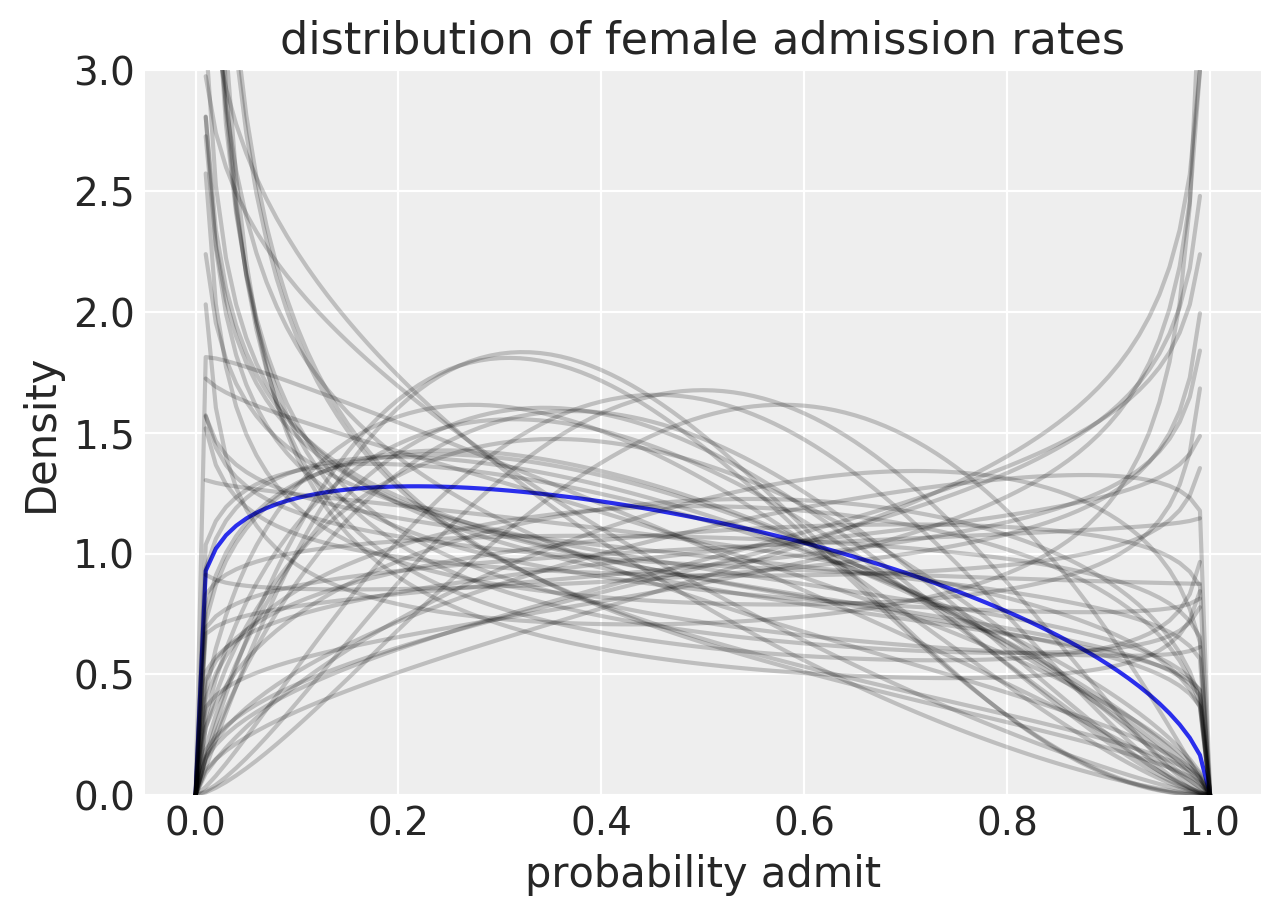

In [16]:
gid = 1
# draw posterior mean beta distribution
x = np.linspace(0, 1, 101)
pbar = tf.reduce_mean(tf.sigmoid(sample_alpha[:, gid]))
theta = tf.reduce_mean(sample_theta)
plt.plot(x, tf.exp(tfd.Beta(pbar * theta, (1 - pbar) * theta).log_prob(x)))
plt.gca().set(ylabel="Density", xlabel="probability admit", ylim=(0, 3));

# draw 50 beta distributions sampled from posterior
for i in range(50):
    p = tf.sigmoid(sample_alpha[i, gid])
    theta = sample_theta[i]
    plt.plot(x, tf.exp(tfd.Beta(p * theta, (1 - p) * theta).log_prob(x)),
             "k", alpha=0.2)
plt.title("distribution of female admission rates");

## Code 12.5

In [17]:
# get samples given the posterior distribution
N = tf.cast(d.applications.values, dtype=tf.float32)
gid = d.gid.values

sample_pbar = tf.sigmoid(tf.squeeze(tf.gather(sample_alpha, gid, axis=-1)))    

# need to reshape it to make it happy
st = tf.reshape(sample_theta, shape=(1000,1))

# prepare the concentration vector
concentration1 = sample_pbar * st
concentration0 = (1 - sample_pbar) * st    

concentration = tf.stack([concentration1, concentration0], axis=-1)

dist = tfd.DirichletMultinomial(total_count=N, concentration=concentration)

predictive_samples = dist.sample()

In [18]:
# numpy style indexing magic ! .. hate it !
admit_rate = predictive_samples[::,::,0] / N

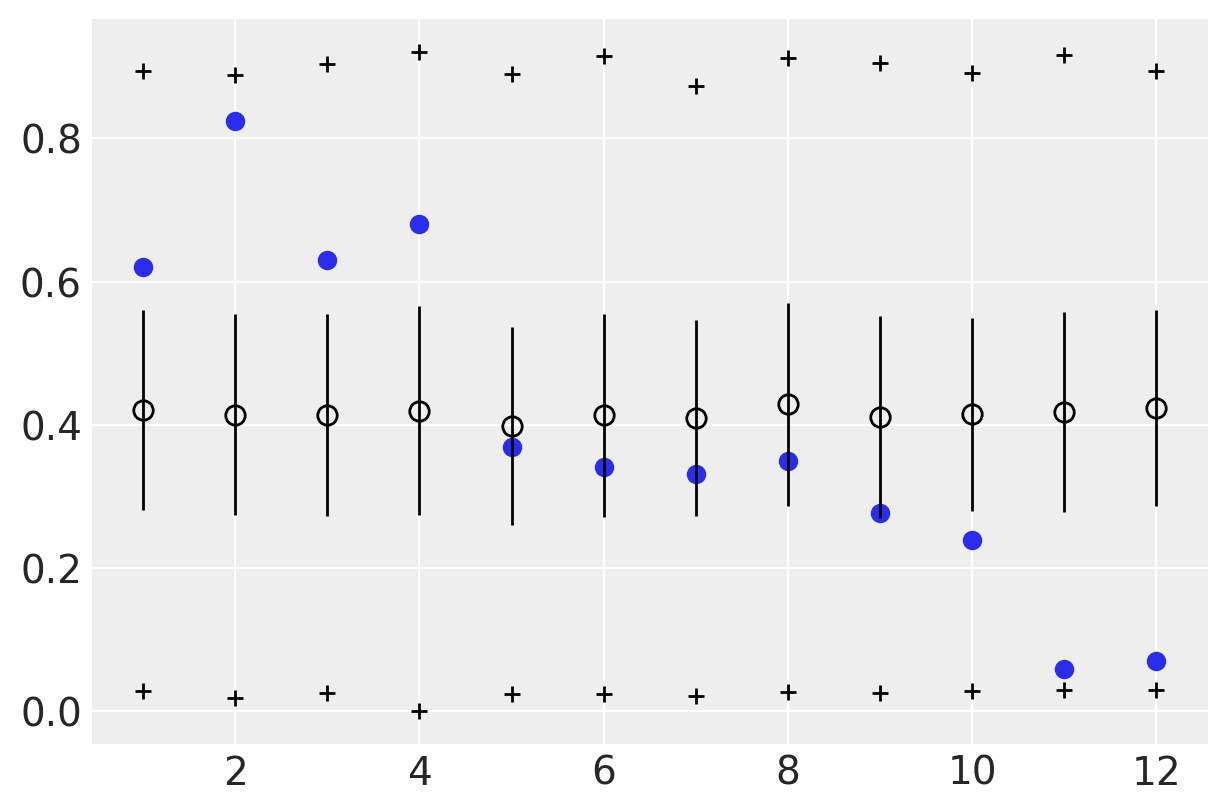

In [19]:
plt.scatter(range(1, 13), d.admit.values /N)
plt.errorbar(range(1, 13), np.mean(admit_rate, 0), np.std(admit_rate, 0) / 2,
             fmt="o", c="k", mfc="none", ms=7, elinewidth=1)
plt.plot(range(1, 13), np.percentile(admit_rate, 5.5, 0), "k+")
plt.plot(range(1, 13), np.percentile(admit_rate, 94.5, 0), "k+");

In the above plot, the vertifical axis shows the predicted proportion admitted, for each case on the horizontal.

Blue points show the empirical proportion admitted on each row of data

Open circles are the posterior mean pbar and + symbols mark the 89% interval of predicted counts of admission

## Code 12.6

Start to use **Gamma-Poisson** (also known as **Negative Binomial**) models.

Essentially Gamm-Poisson is about associating a rate to each Posisson count observation. Estimates the shape of gamma distribution to describe the Poisson rates across cases.

Gamma-Poisson also expects more variation around the mean rate.

The negative binomial distribution arises naturally from a probability experiment of performing a series of independent Bernoulli trials until the occurrence of the rth success where r is a positive integer.

In [20]:
d = pd.read_csv(KLINE_DATASET_PATH, sep=";")
d["P"] = d.population.pipe(np.log).pipe(lambda x: (x - x.mean()) / x.std())
d["cid"] = (d.contact == "high").astype(int)

d.head()

,culture,population,contact,total_tools,mean_TU,P,cid
0,Malekula,1100,low,13,3.2,-1.291473,0
1,Tikopia,1500,low,22,4.7,-1.088551,0
2,Santa Cruz,3600,low,24,4.0,-0.515765,0
3,Yap,4791,high,43,5.0,-0.328773,1
4,Lau Fiji,7400,high,33,5.0,-0.044339,1


In [21]:
def model_12_2(cid, P):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=1., scale=1.), sample_shape=2))
      beta = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=2))
      gamma = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      phi = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))

      lambda_ = tf.exp(tf.squeeze(tf.gather(alpha, cid, axis=-1))) * \
              tf.math.pow(P, tf.squeeze(tf.gather(beta, cid, axis=-1))) / gamma
    
      g_concentration = lambda_ / phi
      g_rate = 1 / phi
    
      t1 = yield tfd.Independent(tfd.Gamma(concentration=g_concentration, rate=g_rate), reinterpreted_batch_ndims=1)
        
      T = yield tfd.Independent(tfd.Poisson(rate=t1), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_12_2 = model_12_2(d.cid.values, tf.cast(d.P.values, dtype=tf.float32))

jdc_12_2.sample()

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.0274287, 1.1656541], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.5809435 , 0.05878866], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.4875453], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.33984244], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([1.1754944e-38, 1.1754944e-38, 1.1754944e-38, 1.1754944e-38,
        1.1754944e-38, 6.2314444e+00, 4.0530753e+00, 1.0705230e+00,
        6.5639396e+00, 1.9203766e+01], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([ 0.,  0.,  0.,  0.,  0.,  9.,  9.,  1., 10., 21.], dtype=float32)>)

In [22]:
trace_12_2 = sample_from_posterior(jdc_12_2, 
                                       observed_data=d.total_tools.values, 
                                       params=['alpha', 'beta', 'gamma' 'phi', 't1', 't2'])